In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm # Color maps

from Environment import Environment, MRP, MDP
import utils as u 
import Agent as A

sns.set_theme(font_scale = 0.7)
sns.set_style()

Notes
'The environment obeys the laws/symmetries of the gridworld, but keeps track of everything thats in it, including the agents, thus this is what the agent interacts with '
    """
    Maybe also internal dynamics: t increments are environment steps, additionally
    Since the environment is markov it is not necessary to keep explicit track of the history

    Interaction:
        Gets:
        Action agent At
    
        Emits:
        Observation Ot+1
        Reward Ot+1

    Note that this also entails that the t-increments happen at the environment steps

### Initialization and set-up

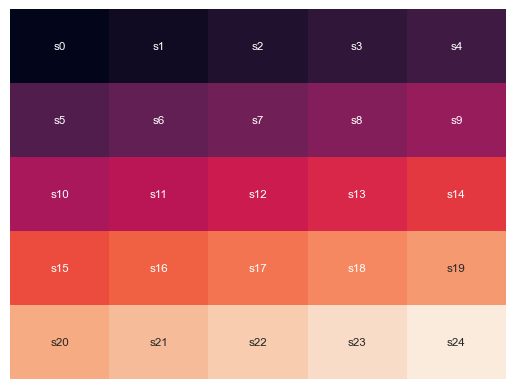

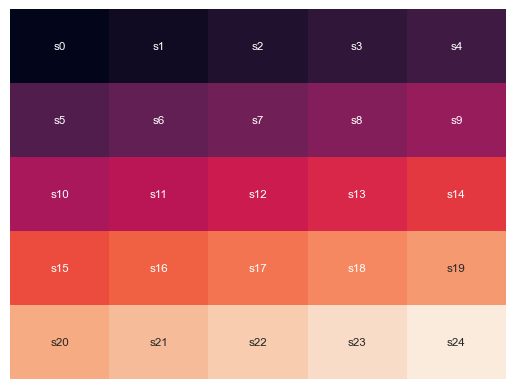

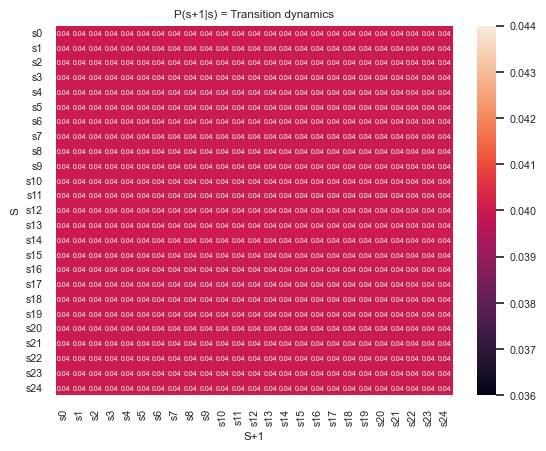

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [5]:
#For the markov process, we need a transition matrix and the possible states, we add some variety by adding obstacle states
width, height = 5, 5
gamma = 0.9
#forbidden_states = []
obstacle_states = [11,12,13]
goal_state = 4
start_state = 15

#set-up environment
env = MRP(width, height, gamma)
#env.add_forbidden_state(obstacle_states)
env.plot_grid()# S
plt.show()

# TO DO -> Adjust transition matrix to recognize forbidden states and compute the appropriate transition matrix, just as with obstacle states
#env.add_obstacle(obstacle_states) 
env.plot_grid()# S
plt.show()
env.plot_dynamics() #P
plt.show()

# Add rewards and discount factor, quite convinced it's useful to keep rewards between -1/1 to foster alignment, give agents the ability to scale, and then align it again, so it's relative to each agent/environment
reward_goal = 1
gamma = 0.9
penalty = -0.1

# I would argue that the penaly steps are something of the agents self, and the goal reward is in the environment
env.R = env.R + penalty #set reward
env.R[env.coordinates[goal_state]] = reward_goal#set reward
env.plot_rewards()

## Value function v(s) = E(Gt | St)

In [18]:
#Bellman expectation equation in matrix form, same
R = np.array([env.R.flatten()]).T
P = env.P
v = np.array([state_values.flatten()]).T

gamma = 0.9
state_values_matrix = np.linalg.inv((np.identity(env.nstates) - (0.9 * P))) @ R# R + gamma * (P@v)
print(state_values_matrix)
# Makes sense, only it doesnt take into account that the goal state is a horizon, however besides it makes sense
print(env.fit_grid(state_values_matrix))

[[-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [ 0.496]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]
 [-0.604]]
[[-0.604 -0.604 -0.604 -0.604  0.496]
 [-0.604 -0.604 -0.604 -0.604 -0.604]
 [-0.604 -0.604 -0.604 -0.604 -0.604]
 [-0.604 -0.604 -0.604 -0.604 -0.604]
 [-0.604 -0.604 -0.604 -0.604 -0.604]]


## Markov Decision Process: fully observable

So up till now we had no physically embodied agent, we just defined a process with several states and no local conditions. So maybe we have to think in the location as a term of constraints? Earlier we only had constraints in the form of inaccessible states or just environment dynamics, now we have an agent that adds additional constraints.

So for local movement, it's also important to make our states and the steps we make a coordinate system, or just translate it to multiple dimensions.

In [19]:
absorbing_state = goal_state

In [20]:
# Okay, so we could enter a reward function that depends on the action or both on the actions and the state, we can incorporate the penalty steps here
# so the environment has a vector for immediate rewards
# Add reward functions for actions, for now penalties equally for all actions will suffice

In [21]:
a = A.Agent_MDP(start_state = 15, env = env, goal_state = goal_state, absorbing_state = absorbing_state)
b = a.run(t_end = 100, env = env, start_state = start_state, goal_state = goal_state)
print(f'(Gt|s = s_start): {env.fit_grid(b)}')

(Gt|s = s_start): [[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [-0.99943608  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


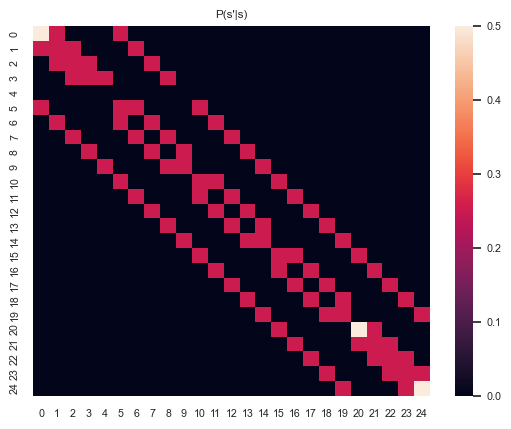

TypeError: Agent_MDP.get_transition_action() missing 1 required positional argument: 'action'

<Figure size 640x480 with 0 Axes>

In [22]:
a.plot_pmatrix_agent()
a.plot_pmatrix_actions(env)

### MDP value function

In [23]:
def value_function_MDP(agent, episodes, visualise = False):
    if visualise == True:
        %matplotlib
        fig = plt.figure()
        ax = fig.add_subplot(projection = '3d')
        ax.set_title('Value function: v(s) = E(gt | st)')
    state_returns = np.zeros(env.nstates)
    for i in range(episodes):
        # Cumulate state returns
        for j in range(env.nstates): #iterate over starting states
             #later: can also keep track of all things within agent
            state_returns = state_returns + agent.run(100, start_state = j)

        # Visualise value function for each episode
        if visualise == True:
            plt.cla()
            ax.plot_surface(env.X1, env.X2, -env.fit_grid(state_returns/(i+1)))
            #sns.heatmap(env.fit_grid(state_returns/(i+1)), cbar = False, annot = True) #expected value
            plt.suptitle(f'episode: {i+1}')
            plt.draw()
            plt.pause(0.1)
        
    # Expected value: State value E(gt | st = 14)
    state_values = state_returns/episodes
    if visualise == True:
        plt.close(fig)
    return env.fit_grid(state_values)

TypeError: Agent_MDP.run() missing 2 required positional arguments: 'env' and 'goal_state'

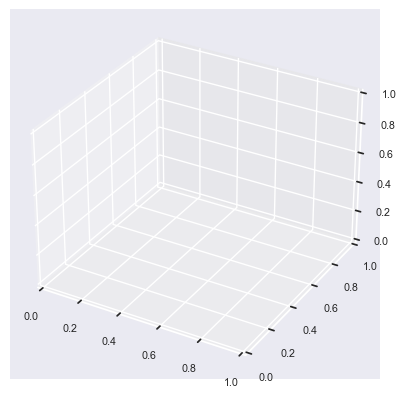

In [26]:
a = A.Agent_MDP(start_state = 15, env = env, goal_state = goal_state, absorbing_state = absorbing_state)
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
v = a.value_function_MDP(episodes = 100, env = env)
plt.title('State value function random policy V(s)')
ax.plot_surface(env.X1, env.X2, -v)
plt.show()
env.heatmap(v)

<Axes: >

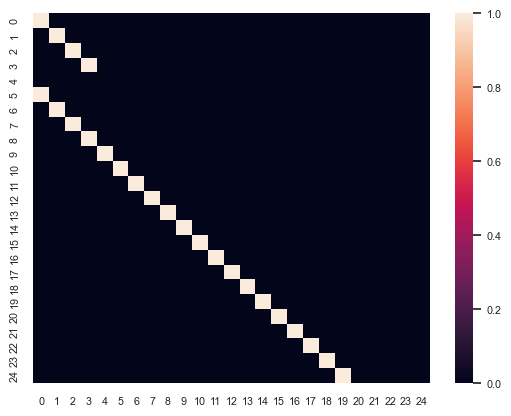

In [ ]:
b = a.get_transition(env, actions = [a.choices[0]])
sns.heatmap(b)

### Action-value function

In [ ]:
def q_function_MDP(agent, episodes, visualise = False):
    state_action_returns = np.zeros((len(agent.choices), env.nstates))
    for i in range(episodes):
        # Cumulate state returns
        for j in range(env.nstates): #iterate over starting states
            #cumulate action returns
            for k in range(len(agent.choices)):
                state_action_returns[k] = state_action_returns[k] + agent.q_run(100, start_state = j, start_action = k)
        
    # Expected value: State value E(gt | st = 14)
    q_values = state_action_returns/episodes
    return q_values#env.fit_grid(state_values)

In [ ]:
a = Agent_MDP(start_state = 15)
q = a.q_function_MDP(episodes = 100)

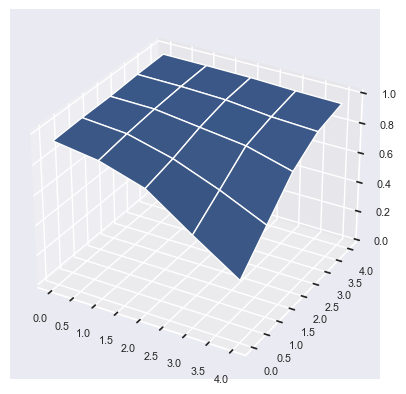

[-0.94092796 -0.89773945 -0.80554605 -0.59596365 -0.39613803 -0.94984017
 -0.92631893 -0.84869163 -0.73183994 -0.59322297 -0.95219917 -0.94689905
 -0.90836523 -0.87031934 -0.78805313 -0.96378852 -0.96002849 -0.94909009
 -0.91789196 -0.90215808 -0.96884057 -0.96686335 -0.96267984 -0.9514291
 -0.94542759]


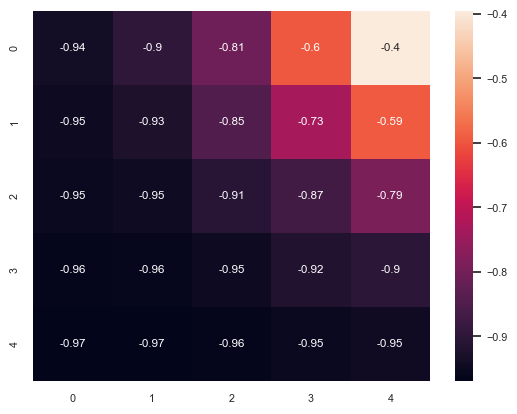

In [ ]:
#v_pi(s) = sum(policy(a|s) * q_pi(s,a))
v = np.sum(q * 0.25, axis = 0) #0.25 since policy is random
env.plot_landscape(-v)
plt.show()
env.heatmap(v)
print(v)

[[-0.94258531 -0.90823071 -0.81421017 -0.58412223  0.        ]
 [-0.95142227 -0.9271103  -0.86770431 -0.75332194 -0.58412223]
 [-0.96298109 -0.94868848 -0.91737676 -0.86770431 -0.81421017]
 [-0.97237967 -0.96448067 -0.94868848 -0.9271103  -0.90823071]
 [-0.97740155 -0.97237967 -0.96298109 -0.95142227 -0.94258531]]


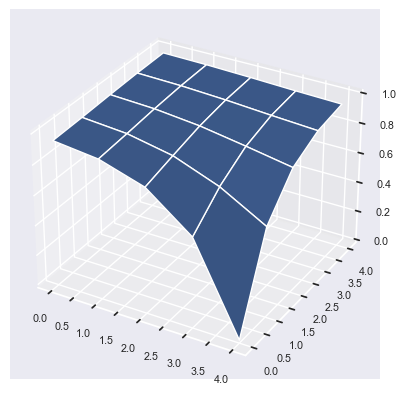

In [ ]:
# Bellman expectation 
R = np.array([np.sum(env.R, axis = 1)/ len(a.choices)]).T

#average P based on q values
P = a.P
value = np.linalg.inv((np.identity(env.nstates) - 0.9 * P)) @ R
env.plot_landscape(-value)
print(env.fit_grid(value))

## Dynamic programming

### Iterative policy evaluation

ite: 322
[[-0.94258531 -0.90823071 -0.81421017 -0.58412223  0.        ]
 [-0.95142227 -0.9271103  -0.86770431 -0.75332194 -0.58412223]
 [-0.96298109 -0.94868848 -0.91737676 -0.86770431 -0.81421017]
 [-0.97237967 -0.96448067 -0.94868848 -0.9271103  -0.90823071]
 [-0.97740155 -0.97237967 -0.96298109 -0.95142227 -0.94258531]]


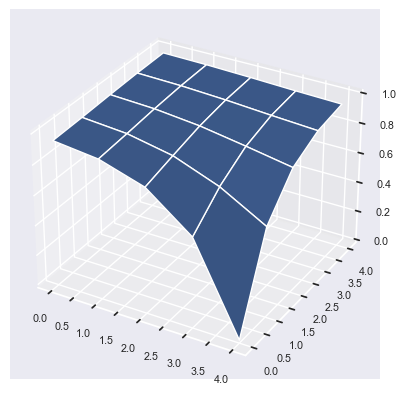

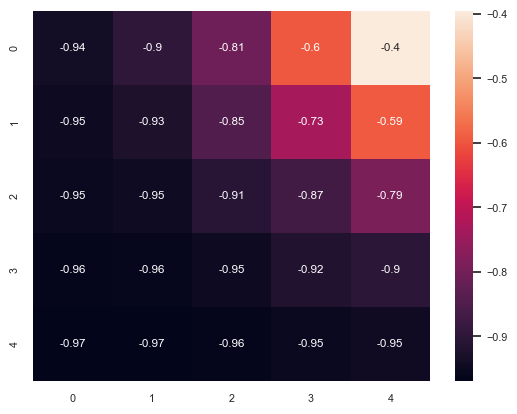

In [ ]:
#Problem: evaluate a given policy pi: synchronous backup
# Search loop policy evaluation
a = Agent_MDP(start_state = 15)
terminate = False
k = 1

#Initial value of v for k = 0
env.absorbing_state = goal_state
q_values = np.ones((env.nstates, len(a.choices)))
v_start = np.sum(q_values * policy, axis = 1)
v_start = np.array([v_start]).T
P = np.zeros((env.nstates, env.nstates))
P = a.P
policy = a.policy
R = np.array([np.sum(env.R, axis = 1)]).T / len(a.choices) #average of rewards
gamma = 0.9

while terminate is False:
    #Bellman expectation matrix
    v_start = np.sum(q_values * policy, axis = 1)
    v_start = np.array([v_start]).T
    vk = R + gamma * (P @ v_start)
    #vk = np.sum(q_values * policy, axis = 1)
    if k == 800 or (vk - v_start).any() == False:
        terminate = True
        print(f"ite: {k}")
        print(env.fit_grid(vk))
        env.plot_landscape(-vk)
        plt.show()
        env.heatmap(v)
    
    k += 1
    v_start = vk

<Axes: >

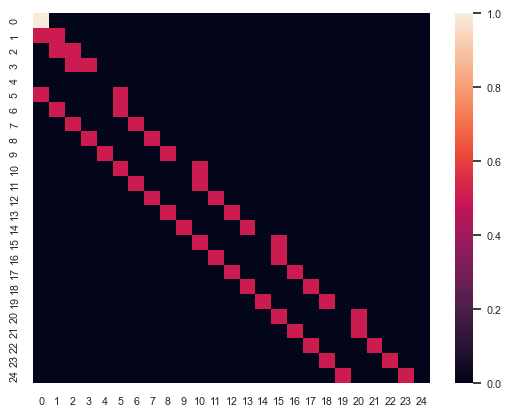

In [ ]:
b = a.get_transition(env, actions = [a.choices[2], a.choices[0]])
sns.heatmap(b)

### Policy iteration

ite: 500
[[0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [0.5  0.   0.   0.5 ]
 [1.   0.   0.   0.  ]]


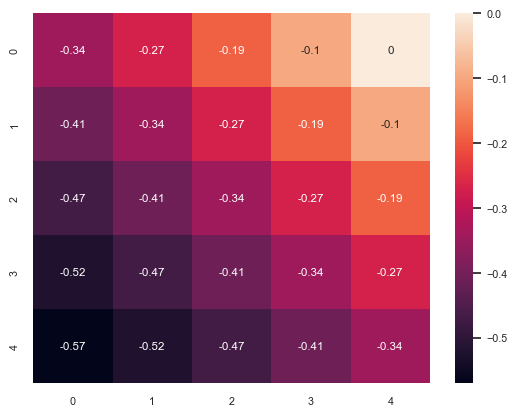

In [ ]:
# Change for loop actions to array
#Problem: evaluate a given policy pi: synchronous backup
# Search loop policy evaluation
a = Agent_MDP(start_state = 15)
terminate = False
k = 1

#Initial value of v for k = 0
env.absorbing_state = goal_state
q_values = np.ones((env.nstates, len(a.choices)))
v_start = np.sum(q_values * policy, axis = 1)
v_start = np.array([v_start]).T
P = np.zeros((env.nstates, env.nstates))
P = a.P
policy = a.policy
R = np.array([np.sum(env.R, axis = 1)]).T / len(a.choices) #average of rewards
gamma = 0.9

while terminate is False:
    #Bellman expectation matrix
    v_start = np.sum(q_values * policy, axis = 1)
    v_start = np.array([v_start]).T
    vk = R + gamma * (P @ v_start)
    #vk = np.sum(q_values * policy, axis = 1)
    if k == 800 or (vk - v_start).any() == False:
        terminate = True
        print(f"ite: {k}")
        print(env.fit_grid(vk))
        env.plot_landscape(-vk)
        plt.show()
        env.heatmap(v)
    
    k += 1
    v_start = vk



# Policy evaluation step
while terminate is False:
    # Policy evalation
    vk = np.sum(q_values * policy, axis = 1)
    # Policy improvement step, greedy: pi'(s) = argmax_a qpi(s,a) -> should be possible with bellman
    q_values = np.zeros((env.nstates, len(a.choices)))
    for j in range(env.nstates):
        for i in range(len(a.choices)):
            immediate_reward = env.R[j][i] 
            
            Pssa = a.get_transition(env, actions = [a.choices[i]]) 
            #sns.heatmap(Pssa)
            q_values[j, i] = immediate_reward + gamma * np.sum(Pssa[j] @ vk)
        best_values = np.argwhere(q_values[j, :] == np.amax(q_values[j, :]))
        policy[j] = normalized(len(a.choices), best_values)
    
    
    #print(policy)
    
    if k == 500 or (vk - v_start).any() == False:
        terminate = True
        print(f"ite: {k}")
        print(policy)
        env.heatmap(vk)
    
    # Environment step
    
    k += 1 

### Value iteration